In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

# import plotting stuff
from utils.plot_utils import *

# import data loading stuff
from utils.data_utils import load_movement_df


path_to_data = os.path.join('..', '..', 'data')
# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [2]:
# load posterior MLEs

RUN_IDS = [1, 2, 3]

γ_prior  = [0.01, 0.9]
β_prior  = [0.001, 0.05]

param_prior_dict      = {}
param_prior_dict["γ"] = γ_prior
param_prior_dict["β"] = β_prior

ρ = 6
posterior_df = []
for idx_oev, run_id in enumerate(RUN_IDS):
    for idx_row, row in scenarios_df.iterrows():
        s_name      = row.name_scenario

        path_to_scenario = os.path.join('..', '..', 'results', 'synthetic_inferences', f'ρ_{ρ}%', row.name_scenario)
        samples          = np.load( os.path.join(path_to_scenario, f'weekly_samples_{run_id}.npz') )
        para_post_all    = samples["param_posterior"]
        param_mean_iter  = samples["theta"]
        param_mean_iter  = param_mean_iter[[0,1],:]
        para_post_iter   = para_post_all.mean(-2) # average over time

        params_label     = [r"$\gamma$", r"$\beta$"]
        truth_list       = [row['γ'], row['β']]

        param_range      = list(param_prior_dict.values())
        gamma_mle        = para_post_iter[0,:,-1]
        beta_mle         = para_post_iter[1,:,-1]

        p_df                = pd.DataFrame(columns=["gamma", "beta", "scenario"])
        p_df["gamma"]       = gamma_mle
        p_df["beta"]        = beta_mle

        p_df["gamma_truth"] = truth_list[0]
        p_df["beta_truth"]  = truth_list[1]

        p_df["scenario"] = "Scenario " + str(idx_row+1)
        p_df["run_id"]   = run_id

        posterior_df.append(p_df)

posterior_df             = pd.concat(posterior_df, ignore_index=True)
posterior_df["type"]     = "MLE"
posterior_df["type_plt"] = posterior_df.apply(lambda x: x.type + " " + str(x.run_id), axis=1)


In [3]:
# Plotting stuff
import seaborn as sns
from utils.plot_utils import *

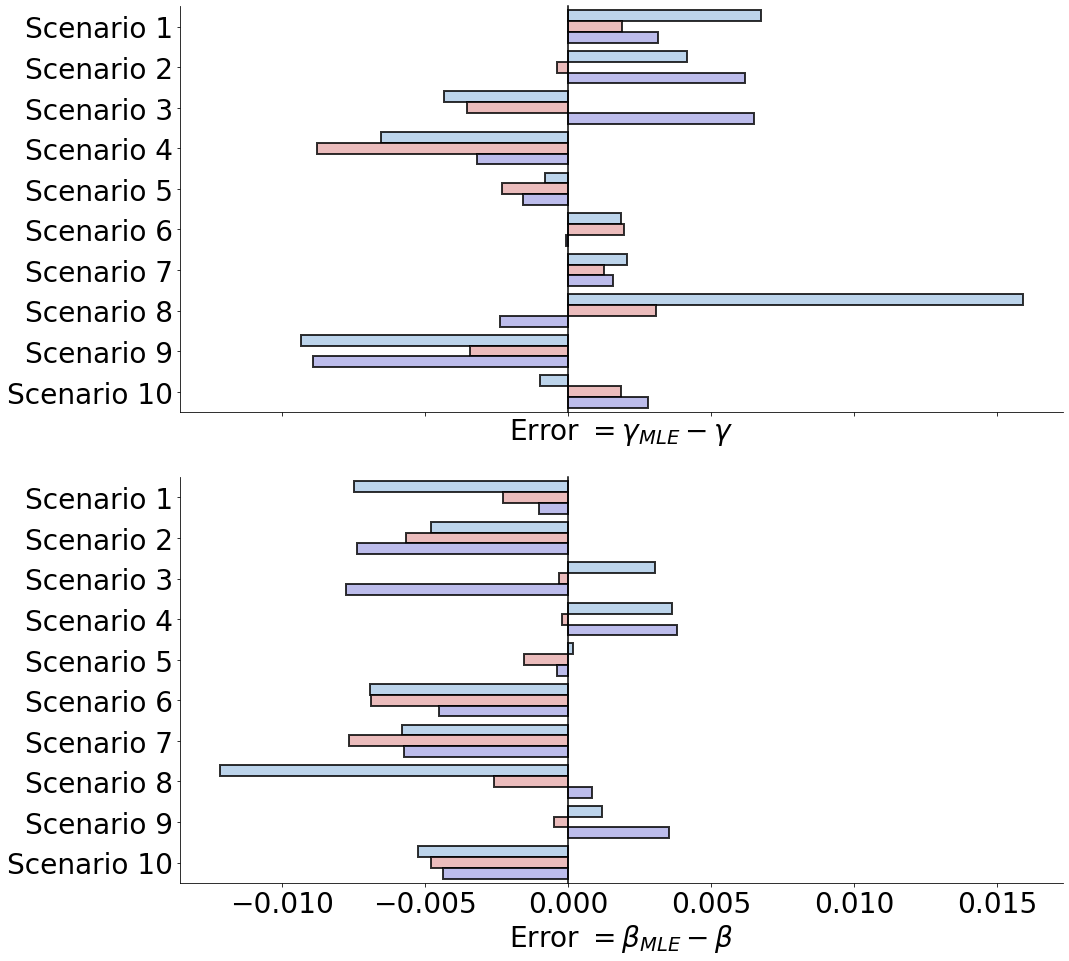

In [4]:
mean_mle_df                = posterior_df.groupby(["scenario", "run_id"]).mean().reset_index()
mean_mle_df["gamma_error"] = mean_mle_df["gamma"] - mean_mle_df["gamma_truth"]
mean_mle_df["beta_error"]  = mean_mle_df["beta"]  - mean_mle_df["beta_truth"]
mean_mle_df["scenario_id"] = mean_mle_df["scenario"].map(lambda x: int(x.split(" ")[-1]))
mean_mle_df                = mean_mle_df.sort_values(by="scenario_id")

mean_mle_df["gamma_relative_error"] = mean_mle_df["gamma_error"] / mean_mle_df["gamma_truth"] * 100
mean_mle_df["beta_relative_error"] = mean_mle_df["beta_error"]  / mean_mle_df["beta_truth"]   * 100

mean_mle_df["gamma_relative_prior_error"] = mean_mle_df["gamma_error"] / (γ_prior[1] - γ_prior[0]) * 100
mean_mle_df["beta_relative_prior_error"]  = mean_mle_df["beta_error"]  / (β_prior[1] - β_prior[0])   * 100

fig, ax = plt.subplots(2, 1, figsize=(15.5, 14), sharey=True, sharex=True)

sns.barplot(ax=ax[0], data=mean_mle_df,  x="gamma_error", y="scenario", hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[0].axvline(0, color="k", clip_on=False)

sns.barplot(ax=ax[1], data=mean_mle_df,  x="beta_error", y="scenario", hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[1].axvline(0, color="k", clip_on=False)

ax[0].set_xlabel(r"Error $= \gamma_{{MLE}}-\gamma$")
ax[1].set_xlabel(r"Error $= \beta_{{MLE}}-\beta$")

ax[0].set_ylabel(None)
ax[1].set_ylabel(None)

sns.despine(right=True, top=True)

ax[0].legend().remove()
ax[1].legend().remove()

plt.tight_layout()
#path_to_save  = os.path.join(path_to_ms_figs, "ErrorMLE.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


In [5]:
from utils.infer_utils import create_df_response
from itertools import chain
def flatten_list(list_array):
    return list(chain(*list_array))

def create_variable_df(abm_settings, samples, variable_name):
    df             = pd.DataFrame(columns=["date", "value", "variable"])
    df["value"]    = samples
    df["date"]     = abm_settings["dates"]
    df["variable"] = [variable_name]*len(abm_settings["dates"])
    return df

In [6]:

def compute_calibration_ward_chunks(ward_chunk_pos, obs_chunk_pos, resample="W-Sun"):
    dates                  = pd.date_range(start=pd.to_datetime("2020-02-01"), periods=ward_chunk_pos.shape[0])
    dates_study            = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq=resample)

    num_ensembles          = ward_chunk_pos.shape[-1]
    num_chunks             = ward_chunk_pos.shape[-2]

    df_ward_sims           = pd.DataFrame(columns=["date"]+[f"pos_{idx_ens}" for idx_ens in range(num_chunks)])
    df_ward_sims["date"]   = flatten_list([ [date]*num_ensembles for date in  list(dates)])
    df_ward_sims["id_ens"] = list(range(num_ensembles)) * len(dates)

    for ward_idx in range(num_chunks):
        ward_pos                        = ward_chunk_pos[:,ward_idx,:]
        df_ward_sims[f"pos_{ward_idx}"] = ward_pos.flatten()

    df_ward_sims = df_ward_sims.set_index(["date", "id_ens"]).unstack([1]).resample(resample).sum().stack().reset_index()#.set_index("date").reset_index()
    df_ward_sims = df_ward_sims[df_ward_sims.date.isin(dates_study)]

    obs_df           = pd.DataFrame(columns=["date"]+[f"pos_{idx_ens}" for idx_ens in range(num_chunks)])
    obs_df["date"]   = dates
    for ward_idx in range(num_chunks):
        ward_pos                  = obs_chunk_pos[:,ward_idx]
        obs_df[f"pos_{ward_idx}"] = ward_pos.flatten()

    obs_df       = obs_df[obs_df.date.isin(dates)].set_index("date")
    obs_df       = obs_df.resample(resample).sum().reset_index()


    quantiles = [25/100, 50/100, 75/100, 95/100]

    calibration_df = []
    for cluster_id in range(num_chunks):
        cal_df               = pd.DataFrame(columns=["quantiles", "proportion_inside"])
        cal_df["quantiles"]  = quantiles
        cal_df               = cal_df.set_index("quantiles")

        for quant in cal_df.index.values:
            chunk_cluster                               = ward_chunk_pos[:,cluster_id,:]
            df_ward                                     = pd.DataFrame(chunk_cluster)
            df_ward["date"]                             = dates
            df_ward                                     = df_ward.set_index("date").resample(resample).sum().reset_index()
            df_ward                                     = df_ward[df_ward.date.isin(dates_study)].set_index("date")
            df_resume                                   = df_ward.T.quantile(q=[0.5-quant/2, 0.5+quant/2]).T
            df_resume["obs"]                            = obs_df[f"pos_{cluster_id}"].values
            df_resume["calibration"]                    = df_resume.apply(lambda x: x[0.5-quant/2] <= np.double(x.obs) <= x[0.5+quant/2], axis=1)
            cal_df.loc[quant]                           = df_resume["calibration"].sum()/len(df_resume)

        cal_df["cluster_id"] = cluster_id
        calibration_df.append(cal_df)

    calibration_df  = pd.concat(calibration_df).reset_index()
    return calibration_df

In [7]:
movement_df, ward2cluster = load_movement_df(path_to_data, True)

abm_settings                     = {}
abm_settings["num_communities"]  = movement_df.ward_id.unique().shape[0]
abm_settings["num_patients"]     = movement_df.mrn_id.unique().shape[0]
abm_settings["num_wards"]        = movement_df.ward_id.unique().shape[0]
abm_settings["num_wards_chunks"] = 6
abm_settings["dates"]            = np.unique(movement_df.index.values)
abm_settings["num_ensembles"]    = 300


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_90941/460407098.py:1: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True)


In [8]:
from itertools import chain

pos_all_df = []
obs_all_df = []

def create_variable_df(abm_settings, samples, variable_name):
    df             = pd.DataFrame(columns=["date", "value", "variable"])
    df["value"]    = samples
    df["date"]     = abm_settings["dates"]
    df["variable"] = [variable_name]*len(abm_settings["dates"])
    return df

path_to_save_samples_synthetic_test = os.path.join(results_dir, "real_testing", "community", "scenarios_paper_rho_negatives_SEQ", "rho_6%" )
calibration_df = []
mle_df         = []
obs_df         = []

run_id = 1
for idx_row, row in scenarios_df.iterrows():

    scenario_params_name = row["name_scenario"]
    params_dict          = {"γ": row["γ"], "β": row["β"]}

    path_to_save_pid = os.path.join(path_to_save_samples_synthetic_test, scenario_params_name)

    sim_samples = np.load(os.path.join(path_to_save_pid, f'mle_simulation_{run_id}.npz'))

    # # Samples from MLE
    colonized_imported_mle  = np.maximum(sim_samples["ward_chunk_imported"].sum(-2),  0);    colonized_imported_mle_df = create_df_response(colonized_imported_mle.T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
    colonized_mle           = np.maximum(sim_samples["ward_chunk_colonized"].sum(-2), 0);    colonized_mle_df          = create_df_response(colonized_mle.T         , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
    positive_mle            = np.maximum(sim_samples["ward_chunk_positive"].sum(-2),  0);    positive_mle_df           = create_df_response(positive_mle.T          , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()

    nosocomial_mle          = sim_samples["ward_chunk_colonized"].sum(-2)-sim_samples["ward_chunk_imported"].sum(-2);              nosocomial_mle_df         = create_df_response(nosocomial_mle.T        , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()


    ward_colonized_imp_mle  = sim_samples["ward_imported"];     ward_colonized_imp_mle_df = pd.concat([create_df_response(ward_colonized_imp_mle[:,idx,:].T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_nosocomial_mle     = sim_samples["ward_nosocomial"];   ward_nosocomial_mle_df    = pd.concat([create_df_response(ward_nosocomial_mle[:,idx,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_colonized_mle      = sim_samples["ward_colonized"];    ward_colonized_mle_df     = pd.concat([create_df_response(ward_colonized_mle[:,idx,:].T,     time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_positive_mle       = sim_samples["ward_positive"];     ward_positive_mle_df      = pd.concat([create_df_response(ward_positive_mle[:,idx,:].T,      time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])

    ward_chunk_colonized_imp_mle  = sim_samples["ward_chunk_imported"]; ward_chunk_colonized_imp_mle_df = pd.concat([create_df_response(ward_chunk_colonized_imp_mle[:,idx_chunk,:].T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_colonized_mle      = sim_samples["ward_chunk_colonized"];          ward_chunk_colonized_mle_df     = pd.concat([create_df_response(ward_chunk_colonized_mle[:,idx_chunk,:].T,     time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_positive_mle       = sim_samples["ward_chunk_positive"];           ward_chunk_positive_mle_df      = pd.concat([create_df_response(ward_chunk_positive_mle[:,idx_chunk,:].T,      time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])

    ward_chunk_nosocomial_mle     = sim_samples["ward_chunk_nosocomial"];                  ward_chunk_nosocomial_mle_df    = pd.concat([create_df_response(ward_chunk_nosocomial_mle[:,idx_chunk,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_nosocomial_mle     = ward_chunk_colonized_mle-ward_chunk_colonized_imp_mle;  ward_chunk_nosocomial_mle_df    = pd.concat([create_df_response(ward_chunk_nosocomial_mle[:,idx_chunk,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])

    # compute nosocomial from total colonizations and importations
    #ward_chunk_nosocomial_mle_df               =  pd.concat([create_df_response(ward_chunk_colonized_mle[:,idx_chunk,:].T-ward_chunk_colonized_imp_mle[:,idx_chunk,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_colonized_imp_mle_df["cluster"] =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_nosocomial_mle_df["cluster"]    =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_colonized_mle_df["cluster"]     =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_positive_mle_df["cluster"]      =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))

    ward_chunk_colonized_imp_mle_df["variable"] = "ward_chunk_imported"
    ward_chunk_nosocomial_mle_df["variable"]    = "ward_chunk_nosocomial"
    ward_chunk_colonized_mle_df["variable"]     = "ward_chunk_colonized"
    ward_chunk_positive_mle_df["variable"]      = "ward_chunk_positive"
    colonized_imported_mle_df["variable"]       = "imported"
    nosocomial_mle_df["variable"]               = "nosocomial"
    colonized_mle_df["variable"]                = "colonized"
    positive_mle_df["variable"]                 = "positive"

    # concatenate mle results
    results_mle_df = pd.concat([colonized_mle_df, colonized_imported_mle_df, nosocomial_mle_df, positive_mle_df, ward_chunk_colonized_mle_df, ward_chunk_colonized_imp_mle_df, ward_chunk_positive_mle_df, ward_chunk_nosocomial_mle_df])
    results_mle_df["scenario"] = scenario_params_name

    ##### LOAD OBSERVATION USED FOR THE INFERENCE #####
    samples_infer                   = np.load(os.path.join(path_to_save_pid, f'simulation_infer_{run_id}.npz'))
    idx_infer                       = samples_infer['idx_use']
    colonized_imported_infer        = samples_infer["ward_colonized_imported"].sum(-2)[:len(abm_settings["dates"]),idx_infer];             colonized_imported_df  = create_variable_df(abm_settings, colonized_imported_infer, variable_name="colonized_imported")
    nosocomial_infer                = samples_infer["ward_positive"].sum(-2)[:len(abm_settings["dates"]),idx_infer];                       nosocomial_df          = create_variable_df(abm_settings, nosocomial_infer, variable_name="nosocomial")
    colonized_infer                 = samples_infer["ward_colonized"].sum(-2)[:len(abm_settings["dates"]),idx_infer];                      colonized_df           = create_variable_df(abm_settings, colonized_infer, variable_name="colonized")
    positive_infer                  = samples_infer["ward_nosocomial"].sum(-2)[:len(abm_settings["dates"]),idx_infer];                     positive_df            = create_variable_df(abm_settings, positive_infer, variable_name="positive")

    ward_colonized_imp_infer       = samples_infer["ward_colonized_imported"][:len(abm_settings["dates"]),:,idx_infer];      ward_colonized_imp_df  =  pd.concat([create_variable_df(abm_settings, ward_colonized_imp_infer[:,idx], variable_name="ward_colonized_imported") for idx in range(abm_settings["num_wards"])])
    ward_colonized_infer           = samples_infer["ward_colonized"][:len(abm_settings["dates"]),:,idx_infer];               ward_colonized_df      =  pd.concat([create_variable_df(abm_settings, ward_colonized_infer[:,idx], variable_name="ward_colonized") for idx in range(abm_settings["num_wards"])])
    ward_positive_infer            = samples_infer["ward_positive"][:len(abm_settings["dates"]),:,idx_infer];                ward_positive_df       =  pd.concat([create_variable_df(abm_settings, ward_positive_infer[:,idx], variable_name="ward_positive") for idx in range(abm_settings["num_wards"])])

    ward_nosocomial_infer          = samples_infer["ward_nosocomial"][:len(abm_settings["dates"]),:,idx_infer];              ward_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_nosocomial_infer[:,idx], variable_name="ward_nosocomial") for idx in range(abm_settings["num_wards"])])
    ward_nosocomial_infer          = ward_colonized_infer-ward_colonized_imp_infer;                                          ward_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_nosocomial_infer[:,idx], variable_name="ward_nosocomial") for idx in range(abm_settings["num_wards"])])

    ward_colonized_imp_df["ward"] =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_nosocomial_df["ward"]    =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_colonized_df["ward"]     =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_positive_df["ward"]      =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))

    ward_chunk_colonized_imp_infer  = samples_infer["chunk_colonized_imported"][:len(abm_settings["dates"]),:,idx_infer]; ward_chunk_colonized_imp_df  =  pd.concat([create_variable_df(abm_settings, ward_chunk_colonized_imp_infer[:,idx_chunk], variable_name="ward_chunk_colonized_imported") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_colonized_infer      = samples_infer["chunk_colonized"][:len(abm_settings["dates"]),:,idx_infer];          ward_chunk_colonized_df      =  pd.concat([create_variable_df(abm_settings, ward_chunk_colonized_infer[:,idx_chunk], variable_name="ward_chunk_colonized") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_positive_infer       = samples_infer["chunk_positive"][:len(abm_settings["dates"]),:,idx_infer];           ward_chunk_positive_df       =  pd.concat([create_variable_df(abm_settings, ward_chunk_positive_infer[:,idx_chunk], variable_name="ward_chunk_positive") for idx_chunk in range(abm_settings["num_wards_chunks"])])

    ward_chunk_nosocomial_infer     = samples_infer["chunk_nosocomial"][:len(abm_settings["dates"]),:,idx_infer];         ward_chunk_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_chunk_nosocomial_infer[:,idx_chunk], variable_name="ward_chunk_nosocomial") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_nosocomial_infer     = ward_chunk_colonized_infer-ward_chunk_colonized_imp_infer;                          ward_chunk_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_chunk_nosocomial_infer[:,idx_chunk], variable_name="ward_chunk_nosocomial") for idx_chunk in range(abm_settings["num_wards_chunks"])])


    colonized_imported_infer        = ward_chunk_colonized_imp_infer.sum(1);             colonized_imported_df  = create_variable_df(abm_settings, colonized_imported_infer, variable_name="colonized_imported")
    nosocomial_infer                = ward_chunk_nosocomial_infer.sum(1);                nosocomial_df          = create_variable_df(abm_settings, nosocomial_infer, variable_name="nosocomial")
    colonized_infer                 = ward_chunk_colonized_infer.sum(1);                 colonized_df           = create_variable_df(abm_settings, colonized_infer, variable_name="colonized")
    positive_infer                  = ward_chunk_positive_infer.sum(1);                  positive_df            = create_variable_df(abm_settings, positive_infer, variable_name="positive")


    ward_chunk_colonized_imp_df["cluster"] =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_nosocomial_df["cluster"]    =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_colonized_df["cluster"]     =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_positive_df["cluster"]      =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))

    observations_infer_df             = pd.concat([colonized_df, colonized_imported_df, positive_df, nosocomial_df, ward_chunk_colonized_df, ward_chunk_colonized_imp_df, ward_chunk_positive_df, ward_chunk_nosocomial_df ]) #, ward_colonized_imp_df, ward_nosocomial_df, ward_colonized_df, ward_positive_df ])
    observations_infer_df["scenario"] = scenario_params_name
    observations_infer_df["date"]     = pd.to_datetime(observations_infer_df["date"])

    mle_df.append(results_mle_df)
    obs_df.append(observations_infer_df)

    # compute calibration stats
    cal_colonization_df = compute_calibration_ward_chunks(ward_chunk_colonized_mle, ward_chunk_colonized_infer, resample="W-Sun");         cal_colonization_df["variable"] = "colonized";  cal_colonization_df["scenario"] = scenario_params_name
    cal_importation_df  = compute_calibration_ward_chunks(ward_chunk_colonized_imp_mle, ward_chunk_colonized_imp_infer, resample="W-Sun"); cal_importation_df["variable"]  = "imported";   cal_importation_df["scenario"]  = scenario_params_name
    cal_nosocomial_df   = compute_calibration_ward_chunks(ward_chunk_nosocomial_mle, ward_chunk_nosocomial_infer, resample="W-Sun");       cal_nosocomial_df["variable"]   = "nosocomial"; cal_nosocomial_df["scenario"]   = scenario_params_name
    cal_positive_df     = compute_calibration_ward_chunks(ward_chunk_positive_mle, ward_chunk_positive_infer, resample="W-Sun");           cal_positive_df["variable"]     = "positive";   cal_positive_df["scenario"]     = scenario_params_name

    calibration_df.extend([cal_colonization_df, cal_importation_df, cal_nosocomial_df, cal_positive_df])

calibration_df = pd.concat(calibration_df).reset_index()
mle_df         = pd.concat(mle_df).reset_index(drop=True)
obs_df         = pd.concat(obs_df).reset_index(drop=True)

obs_w_df = obs_df.set_index(["date", "variable", "cluster", "scenario"]).unstack([1,2,3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
mle_w_df = mle_df.set_index(["date", "variable", "cluster", "scenario"]).unstack([1,2,3]).resample("W-Sun").sum().stack().stack().stack().reset_index()


In [ ]:
scenarios_df["scenario_id"] = scenarios_df["name_scenario"].apply(lambda x: int(x[-1]))
scenarios_use_df            = scenarios_df[scenarios_df.scenario_id.isin([1, 3, 5, 7, 9])]


In [ ]:
# First figure: Violin plots MLEs
fig     = plt.figure(constrained_layout=True, figsize=(27, 26))
subfigs = fig.subfigures(3, 1, hspace=0.07, wspace=0.1,  height_ratios=[0.2, 0.3, 0.1])

axes1    = subfigs[0].subplots(1, 2, sharey=True)

run_id = 1
sns.violinplot(ax=axes1[0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)
sns.violinplot(ax=axes1[1], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)

run_id = 2
sns.violinplot(ax=axes1[0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
sns.violinplot(ax=axes1[1], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)

run_id = 3
sns.violinplot(ax=axes1[0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
sns.violinplot(ax=axes1[1], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)


sns.scatterplot(ax=axes1[0], data=posterior_df.drop_duplicates(subset="scenario", keep="first"), x="gamma_truth", y="scenario", s=150, facecolor="red", edgecolor="k", marker="o", label="Truth", lw=20)
sns.scatterplot(ax=axes1[1], data=posterior_df.drop_duplicates(subset="scenario", keep="first"), x="beta_truth", y="scenario",  s=150, facecolor="red", edgecolor="k", marker="o", label="Truth",  lw=20)

axes1[0].legend(title="Type", loc="upper right")

sns.despine(right=True, top=True)

axes1[1].legend().remove()
axes1[0].set_xlabel(r"Importation Rate - $\gamma$")
axes1[1].set_xlabel(r"In-Hospital transmission rate - $\beta$")
axes1[0].set_ylabel(None)
axes1[1].set_ylabel(None)


axes1  = subfigs[1].subplots(3, 5, sharey=False, sharex=True)
imp_df = mle_w_df[mle_w_df.variable=="imported"]
var_df = obs_w_df[obs_w_df.variable=="colonized_imported"]

for idx_sce, sce_row in scenarios_use_df.reset_index().iterrows():
    imp_p_df = imp_df[imp_df.scenario==sce_row.name_scenario]
    var_p_df = var_df[var_df.scenario==sce_row.name_scenario]

    sns.lineplot(ax=axes1[0, idx_sce], data=imp_p_df, x="date", y="median", linewidth=1, color="salmon")
    axes1[0, idx_sce].fill_between(imp_p_df.date, imp_p_df.low_95, imp_p_df.high_95, color="salmon", alpha=0.3, label="Imported Sim")
    axes1[0, idx_sce].fill_between(imp_p_df.date, imp_p_df.low_50, imp_p_df.high_50, color="salmon", alpha=0.3)
    sns.scatterplot(ax=axes1[0, idx_sce], data=var_p_df, x="date", y="value", label="Imported Data", edgecolor="k", facecolor="salmon", s=30)

    format_axis(axes1[0, idx_sce], week=False)

noso_df = mle_w_df[mle_w_df.variable=="nosocomial"]
var_df = obs_w_df[obs_w_df.variable=="nosocomial"]

for idx_sce, sce_row in scenarios_use_df.reset_index().iterrows():
    noso_p_df = noso_df[noso_df.scenario==sce_row.name_scenario]
    var_p_df  = var_df[var_df.scenario==sce_row.name_scenario]

    sns.lineplot(ax=axes1[1, idx_sce], data=noso_p_df, x="date", y="median", linewidth=1, color="lightskyblue")
    axes1[1, idx_sce].fill_between(noso_p_df.date, noso_p_df.low_95, noso_p_df.high_95, color="lightskyblue", alpha=0.3, label="Imported Sim")
    axes1[1, idx_sce].fill_between(noso_p_df.date, noso_p_df.low_50, noso_p_df.high_50, color="lightskyblue", alpha=0.3)
    sns.scatterplot(ax=axes1[1, idx_sce], data=var_p_df, x="date", y="value", label="Nosocomial Data", edgecolor="k", facecolor="lightskyblue", s=30)
    axes1[0, idx_sce].set_title(sce_row.name_scenario.capitalize())
    format_axis(axes1[1, idx_sce], week=False)


pos_df = mle_w_df[mle_w_df.variable=="positive"]
var_df = obs_w_df[obs_w_df.variable=="positive"]

for idx_sce, sce_row in scenarios_use_df.reset_index().iterrows():
    pos_p_df = pos_df[pos_df.scenario==sce_row.name_scenario]
    var_p_df  = var_df[var_df.scenario==sce_row.name_scenario]

    sns.lineplot(ax=axes1[2, idx_sce], data=pos_p_df, x="date", y="median", linewidth=1, color="lightseagreen")
    axes1[2, idx_sce].fill_between(pos_p_df.date, pos_p_df.low_95, pos_p_df.high_95, color="lightseagreen", alpha=0.3, label="Imported Sim")
    axes1[2, idx_sce].fill_between(pos_p_df.date, pos_p_df.low_50, pos_p_df.high_50, color="lightseagreen", alpha=0.3)
    sns.scatterplot(ax=axes1[2, idx_sce], data=var_p_df, x="date", y="value", label="Imported Data", edgecolor="k", facecolor="k", s=30)
    format_axis(axes1[2, idx_sce], week=False)

    x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
    x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]

    axes1[2, idx_sce].set_xticks(x_ticks_pos, x_ticks_labels)
for axi in axes1.flatten():
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    axi.legend().remove()

axes1[0, 0].set_ylabel(r"Imported")
axes1[1, 0].set_ylabel(r"Nosocomial")
axes1[2, 0].set_ylabel(r"Positives")


axes3    = subfigs[2].subplots(1, 5, sharey=False, sharex=True)

cal_df = calibration_df[calibration_df.variable=="positive"]
cal_df = cal_df[cal_df.cluster_id==1]

identity = np.arange(0,1, 0.01)

for idx_sce, sce_row in scenarios_use_df.reset_index().iterrows():
    cal_plt_df    = cal_df[cal_df.scenario==sce_row.name_scenario]
    sns.lineplot(ax=axes3[idx_sce], data=cal_plt_df, x="quantiles", y="proportion_inside", marker="o", lw=5, ms=15, mfc="w", mec="k", color="salmon")
    axes3[idx_sce].plot(identity, identity, color="k", linestyle="--", lw=3, label="y=x")
    axes3[idx_sce].set_title(sce_row.name_scenario.capitalize())
    axes3[idx_sce].set_xlabel("Predicted CI")
    axes3[idx_sce].set_ylabel(None)
    axes3[idx_sce].legend().remove()

axes3[0].set_ylabel("Observed")

################################################################################################################################
path_to_save  = os.path.join(os.path.join(paper_dir, "paper_01", "FinalFigures"), "FIGURE4pannel.png")
fig.savefig(path_to_save, dpi=300, transparent=True)


In [ ]:

fig, axes1    = plt.subplots(3, 5, figsize=(27, 12.2), sharey=False, sharex=True)

imp_df = mle_w_df[mle_w_df.variable=="imported"]
var_df = obs_w_df[obs_w_df.variable=="colonized_imported"]

for idx_sce, sce_row in scenarios_use_df.reset_index().iterrows():
    imp_p_df = imp_df[imp_df.scenario==sce_row.name_scenario]
    var_p_df = var_df[var_df.scenario==sce_row.name_scenario]

    sns.lineplot(ax=axes1[0, idx_sce], data=imp_p_df, x="date", y="median", linewidth=1, color="salmon")
    axes1[0, idx_sce].fill_between(imp_p_df.date, imp_p_df.low_95, imp_p_df.high_95, color="salmon", alpha=0.3, label="Imported Sim")
    axes1[0, idx_sce].fill_between(imp_p_df.date, imp_p_df.low_50, imp_p_df.high_50, color="salmon", alpha=0.3)
    sns.scatterplot(ax=axes1[0, idx_sce], data=var_p_df, x="date", y="value", label="Imported Data", edgecolor="k", facecolor="salmon", s=30)
    format_axis(axes1[0, idx_sce], week=False)

noso_df = mle_w_df[mle_w_df.variable=="nosocomial"]
var_df  = obs_w_df[obs_w_df.variable=="nosocomial"]

for idx_sce, sce_row in scenarios_use_df.reset_index().iterrows():
    noso_p_df = noso_df[noso_df.scenario==sce_row.name_scenario]
    var_p_df  = var_df[var_df.scenario==sce_row.name_scenario]

    sns.lineplot(ax=axes1[1, idx_sce], data=noso_p_df, x="date", y="median", linewidth=1, color="lightskyblue")
    axes1[1, idx_sce].fill_between(noso_p_df.date, noso_p_df.low_95, noso_p_df.high_95, color="lightskyblue", alpha=0.3, label="Imported Sim")
    axes1[1, idx_sce].fill_between(noso_p_df.date, noso_p_df.low_50, noso_p_df.high_50, color="lightskyblue", alpha=0.3)
    sns.scatterplot(ax=axes1[1, idx_sce], data=var_p_df, x="date", y="value", label="Nosocomial Data", edgecolor="k", facecolor="lightskyblue", s=30)
    axes1[0, idx_sce].set_title(sce_row.name_scenario.capitalize())
    format_axis(axes1[1, idx_sce], week=False)


pos_df = mle_w_df[mle_w_df.variable=="positive"]
var_df = obs_w_df[obs_w_df.variable=="positive"]

for idx_sce, sce_row in scenarios_use_df.reset_index().iterrows():
    pos_p_df = pos_df[pos_df.scenario==sce_row.name_scenario]
    var_p_df  = var_df[var_df.scenario==sce_row.name_scenario]

    sns.lineplot(ax=axes1[2, idx_sce], data=pos_p_df, x="date", y="median", linewidth=1, color="lightseagreen")
    axes1[2, idx_sce].fill_between(pos_p_df.date, pos_p_df.low_95, pos_p_df.high_95, color="lightseagreen", alpha=0.3, label="Imported Sim")
    axes1[2, idx_sce].fill_between(pos_p_df.date, pos_p_df.low_50, pos_p_df.high_50, color="lightseagreen", alpha=0.3)
    sns.scatterplot(ax=axes1[2, idx_sce], data=var_p_df, x="date", y="value", label="Imported Data", edgecolor="k", facecolor="k", s=30)
    format_axis(axes1[2, idx_sce], week=False)

    x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
    x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]

    axes1[2, idx_sce].set_xticks(x_ticks_pos, x_ticks_labels)
for axi in axes1.flatten():
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    axi.legend().remove()

axes1[0, 0].set_ylabel(r"Imported")
axes1[1, 0].set_ylabel(r"Nosocomial")
axes1[2, 0].set_ylabel(r"Positives")

################################################################################################################################
path_to_save  = os.path.join(os.path.join("."), "syntheticFitPPTX.png")
fig.savefig(path_to_save, dpi=300, transparent=True)